In [16]:
import boto3
import pandas as pd
from hatchet_sdk import new_client
from pydantic import AnyUrl

from epengine.models.shoebox import ShoeboxSimulationSpec

exp_id = "test-w-1000-3maxruns"
spec = ShoeboxSimulationSpec(
    experiment_id=exp_id,
    sort_index=0,
    lib_uri=AnyUrl("s3://ml-for-bem/tiles/massachusetts/2024_09_30/everett_lib.json"),
    retrofit="Shallow Retrofit",
    retrofit_lib_uri=AnyUrl(
        "s3://ml-for-bem/tiles/massachusetts/2024_09_30/everett_retrofits.yaml"
    ),
    typology="Residential",
    year_built=1972,
    num_floors=3,
    neighbor_polys=["POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))"],
    neighbor_floors=[3],
    rotated_rectangle="POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))",
    long_edge=10,
    short_edge=10,
    long_edge_angle=0.23,
    footprint_area=100,
    epwzip_path="https://climate.onebuilding.org/WMO_Region_4_North_and_Central_America/USA_United_States_of_America/MA_Massachusetts/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023.zip",
)
specs = []
n = 1000
for i in range(n):
    spec.retrofit = [None, "Shallow Retrofit", "Deep Retrofit"][i % 3]
    spec.long_edge = (i / (n - 1)) * 20 + 10
    spec.sort_index = i
    spec.year_built = list(range(1900, 2020, 10))[i % 12]
    print(spec.sort_index, spec.year_built)
    specs.append(spec.model_dump(mode="json"))
# specs = [spec.model_dump(mode="json")] * 100
df = pd.DataFrame(specs)
df.to_parquet("shoebox_specs.parquet")
s3 = boto3.client("s3")
key = f"hatchet/{exp_id}/shoebox_specs.parquet"
bucket = "ml-for-bem"
s3.upload_file("shoebox_specs.parquet", bucket, key)
uri = f"s3://{bucket}/{key}"

0 1900
1 1910
2 1920
3 1930
4 1940
5 1950
6 1960
7 1970
8 1980
9 1990
10 2000
11 2010
12 1900
13 1910
14 1920
15 1930
16 1940
17 1950
18 1960
19 1970
20 1980
21 1990
22 2000
23 2010
24 1900
25 1910
26 1920
27 1930
28 1940
29 1950
30 1960
31 1970
32 1980
33 1990
34 2000
35 2010
36 1900
37 1910
38 1920
39 1930
40 1940
41 1950
42 1960
43 1970
44 1980
45 1990
46 2000
47 2010
48 1900
49 1910
50 1920
51 1930
52 1940
53 1950
54 1960
55 1970
56 1980
57 1990
58 2000
59 2010
60 1900
61 1910
62 1920
63 1930
64 1940
65 1950
66 1960
67 1970
68 1980
69 1990
70 2000
71 2010
72 1900
73 1910
74 1920
75 1930
76 1940
77 1950
78 1960
79 1970
80 1980
81 1990
82 2000
83 2010
84 1900
85 1910
86 1920
87 1930
88 1940
89 1950
90 1960
91 1970
92 1980
93 1990
94 2000
95 2010
96 1900
97 1910
98 1920
99 1930
100 1940
101 1950
102 1960
103 1970
104 1980
105 1990
106 2000
107 2010
108 1900
109 1910
110 1920
111 1930
112 1940
113 1950
114 1960
115 1970
116 1980
117 1990
118 2000
119 2010
120 1900
121 1910
122 1920
123

In [17]:
client = new_client()

payload = {
    "workflow_name": "simulate_ubem_shoebox",
    "experiment_id": exp_id,
    "bucket": "ml-for-bem",
    "specs": uri,
    "recursion_map": {"factor": 10, "max_depth": 1},
}
task = client.admin.run_workflow("scatter_gather_recursive", payload)
# task = client.admin.run_workflow("scatter_gather", payload)

1000


(array([334.,   0.,   0.,   0.,   0., 333.,   0.,   0.,   0., 333.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

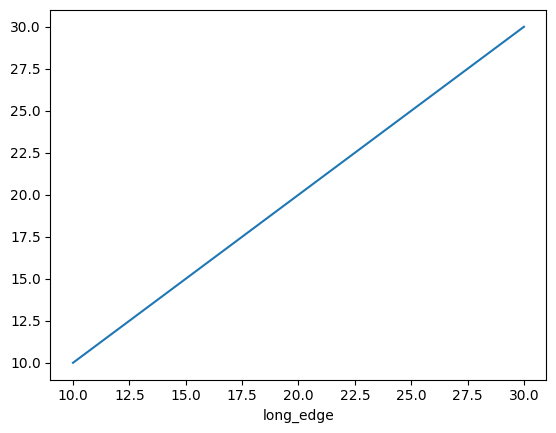

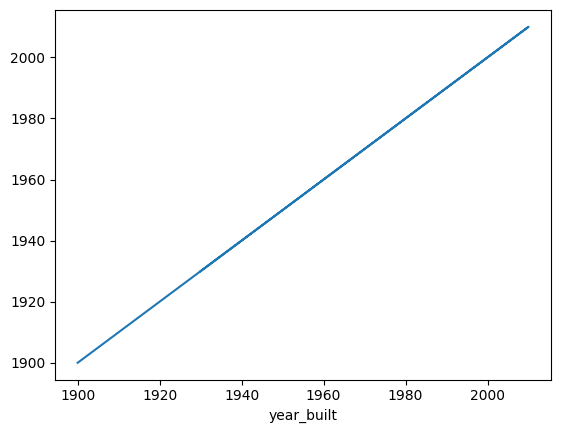

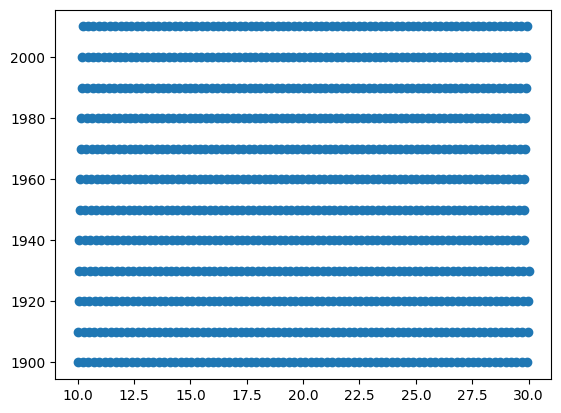

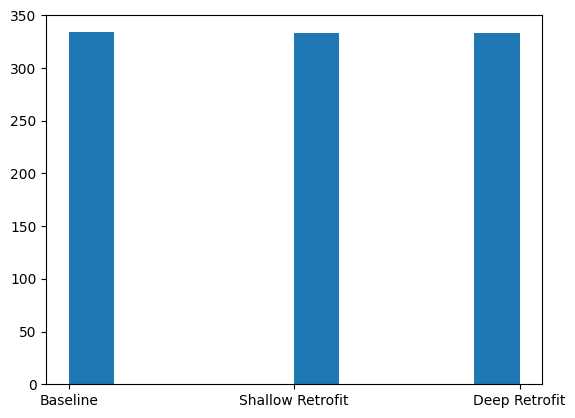

In [18]:
import matplotlib.pyplot as plt

res = await task.result()
uri: str = res["collect_children"]["uri"]
key = uri.split(f"s3://{bucket}/")[-1]
# key = "hatchet/test-w-multi-step-2/results/819c967e-6306-44d0-9694-cdfd55c17ea6.h5"
s3.download_file("ml-for-bem", key, "shoebox_results.h5")
df = pd.read_hdf("shoebox_results.h5")
print(len(df))
fig, ax = plt.subplots()
df.sort_index(level="sort_index").index.get_level_values("long_edge").to_series().plot()
fig, ax = plt.subplots()
df.sort_index(level="sort_index").index.get_level_values(
    "year_built"
).to_series().plot()
long_edges = df.sort_index(level="sort_index").index.get_level_values("long_edge")
years_built = df.sort_index(level="sort_index").index.get_level_values("year_built")
retrofit = df.sort_index(level="sort_index").index.get_level_values("retrofit")
fig, ax = plt.subplots()
plt.scatter(long_edges, years_built)
fig, ax = plt.subplots()
plt.hist(retrofit)